# Projet viager

Émilien Schultz - 3/04/2025

Objectif : faire une approximation de la valeur au m2 d'un bien à partir de sa localisation

- à partir d'une liste d'adresses, les géolocaliser
- calculer à partir des transactions autour de ce bien une moyenne du m2


Chargement des bibliothèques (les installer avant)

In [126]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import yaml

# pour la géolocalisation
import googlemaps

Application :

- https://explore.data.gouv.fr/fr/immobilier?onglet=carte&filtre=tous&lat=48.86123&lng=2.28116&zoom=16.97&level=parcelle&code=75116000DK0041

Données ouvertes disponibles : 

- https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres-geolocalisees/

## Remarques générales

- Pas de donneés pour Alsace/Lorraine

## Exploration des données

Chargement et mise sous forme géographiques 

In [111]:
df = pd.read_csv("./data/full2024.csv", low_memory=False)
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")  # WGS 84
gdf.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,geometry
0,2024-1,2024-01-02,1,Vente,346.5,NaN,NaN,LE DELIVRE,B020,1230.0,...,NaN,NaN,P,prés,NaN,NaN,99.0,5.530952,45.952439,POINT (5.53095 45.95244)
1,2024-2,2024-01-03,2,Vente,10000.0,NaN,NaN,CHEVRY DESSOUS,B007,1170.0,...,NaN,NaN,S,sols,NaN,NaN,115.0,6.043339,46.282256,POINT (6.04334 46.28226)
2,2024-3,2024-01-08,1,Vente,249000.0,NaN,NaN,PIN HAMEAU,B086,1290.0,...,NaN,NaN,S,sols,NaN,NaN,497.0,4.911143,46.247235,POINT (4.91114 46.24724)
3,2024-4,2024-01-03,1,Vente,329500.0,29.0,NaN,PL DU JURA,0500,1170.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,6.058695,46.332212,POINT (6.05870 46.33221)
4,2024-4,2024-01-03,1,Vente,329500.0,29.0,NaN,PL DU JURA,0500,1170.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,6.058695,46.332212,POINT (6.05870 46.33221)


In [121]:
gdf.loc[6]

id_mutation                                         2024-4
date_mutation                                   2024-01-03
numero_disposition                                       1
nature_mutation                                      Vente
valeur_fonciere                                   329500.0
adresse_numero                                        29.0
adresse_suffixe                                        NaN
adresse_nom_voie                                PL DU JURA
adresse_code_voie                                     0500
code_postal                                         1170.0
code_commune                                         01173
nom_commune                                            Gex
code_departement                                        01
ancien_code_commune                                    NaN
ancien_nom_commune                                     NaN
id_parcelle                                 01173000AI0551
ancien_id_parcelle                                     N

In [112]:
gdf["valeur_fonciere"].describe()

count    1.549589e+06
mean     5.851872e+05
std      3.246600e+06
min      1.500000e-01
25%      5.000000e+04
50%      1.485000e+05
75%      2.860000e+05
max      2.550000e+08
Name: valeur_fonciere, dtype: float64

In [113]:
gdf["surface_reelle_bati"].describe()

count    482832.000000
mean        116.663939
std         874.660282
min           1.000000
25%          48.000000
50%          74.000000
75%         103.000000
max      265000.000000
Name: surface_reelle_bati, dtype: float64

Calcul du prix au m2 par bien

In [116]:
gdf["prixm2"] = gdf["valeur_fonciere"] / gdf["surface_reelle_bati"]

### Définition des critères de filtre

Valeurs d'intérêt
- valeur_fonciere
- surface_reelle_bati

Filtres

- nature_mutation == Vente
- type_local in ["Maison", "Appartement"]

Enlever les outliers : prix de moins de 500e/m2, prix de plus de 20000 euros/m2

In [118]:
f1 = (gdf["nature_mutation"] == "Vente")
f2 = (gdf["type_local"] == "Maison") | (gdf["type_local"] == "Appartement")
f3 = gdf["valeur_fonciere"].notna()
f4 = gdf["surface_reelle_bati"].notna()
f5 = (gdf["prixm2"] > 500) & (gdf["prixm2"] < 20000)
f = f1 & f2 & f3 & f4 & f5

# sample
gdf_ss = gdf[f]
gdf_ss.shape

(399576, 42)

Text(0.5, 1.0, 'Distrubution nationale des prix au m2 des transactions pour 2024')

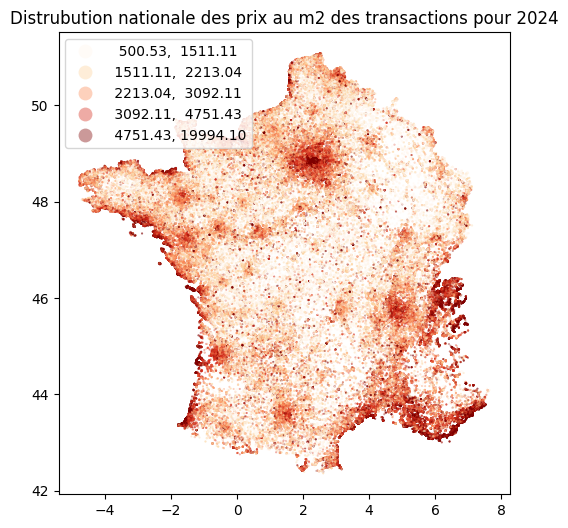

In [122]:
f = (gdf_ss["latitude"] > 40) & (gdf_ss["latitude"] < 60) & (gdf_ss["longitude"] > -5) & (gdf_ss["longitude"] < 8)

fig, ax = plt.subplots(figsize=(8, 6)) 
gdf_ss[f].plot(column = "prixm2", legend=True, marker='.', alpha=0.4, markersize=1, ax=ax, cmap='OrRd', scheme='quantiles')
plt.title("Distribution nationale des prix au m2 des transactions pour 2024")

## Géolocalisation des données

Avec googlemaps, définition d'une fonction

In [135]:
# add a file with the key
key = yaml.safe_load(open("credentials.yml","r"))["key"]

gmaps = googlemaps.Client(key=key)

def get_geoloc(adresse):
    """
    Get geoloc adress
    """
    geocode_result = gmaps.geocode(adresse)
    if geocode_result:
        location = geocode_result[0]['geometry']['location']
        lat, lng = location['lat'], location['lng']
        return (lat, lng)
    else:
        return None

Test sur une donnée

In [138]:
adresse_test = "7 Rue Louis David, Paris"
coord = get_geoloc(adresse_test)
coord

(48.8616641, 2.2814703)

Récupérer les ventes "autour"

In [147]:
# Convert in Mercator (meters)
gdf = gdf_ss.to_crs(epsg=3857) 
point = gpd.GeoSeries([Point(coord[1],coord[0])], crs="EPSG:4326").to_crs(epsg=3857).iloc[0]

# Create a circular zone
buffer = point.buffer(100)

# Filter elements within the buffer
gdf_within = gdf[gdf.geometry.intersects(buffer)]

# Display result
gdf_within

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,geometry,prixm2
1547273,2024-547298,2024-01-19,1,Vente,1059870.0,8.0,NaN,RUE LOUIS DAVID,5776,75016.0,...,2.0,NaN,NaN,NaN,NaN,NaN,2.281121,48.861936,POINT (253933.228 6251467.209),17094.677419
